# Vehicle Detection Solution 
## Create parent folder for custom Model training and child folders to store data 

In [1]:
import shutil
# shutil.unpack_archive("Images.zip")

In [2]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the dataset for Model Training

In [3]:
#### Step 2: Load and preprocess the data 
# Load the labels form labels.csv
labels_df = pd.read_csv("../../Datasets/Capstone_1/Part1/labels.csv", sep=',', header=None)
labels_df.columns = ['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max']

In [4]:
labels_df.head()

,image_id,class,x_min,y_min,x_max,y_max
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45


In [5]:
# Adjust the image IDs in the dataframe
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")

In [6]:
labels_df.tail()

,image_id,class,x_min,y_min,x_max,y_max
351544,00110590,car,18,57,97,98
351545,00110591,articulated_truck,2,71,690,351
351546,00110592,pickup_truck,3,240,214,378
351547,00110592,car,465,111,507,135
351548,00110592,non-motorized_vehicle,197,187,318,269


In [7]:
# use iloc to pick the first 1000 labels
labels_df = labels_df.iloc[:1000]

In [8]:
# Load the correcponding images
image_dir = '../../Datasets/Capstone_1/Part1/Images/'
# Define the target size for all images (e.g., 224x224)
target_size = (224, 224)

In [9]:
images = []
for index, row in labels_df.iterrows():
    image_path = os.path.join(image_dir, f"{row['image_id']}.jpg")
    img = cv2.imread(image_path)
    if img is not None:
        # Ensure the image is in RGB format
        if len(img.shape) == 2:  # If the image is grayscale
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # If the image has an alpha channel
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        
        # Resize the image to the target size
        img_resized = cv2.resize(img, target_size)
        images.append(img_resized)
    else:
        print(f"Error Loading image: {image_path}")
processed_images = np.array(images)

In [10]:
# check if images are loaded
if len(images) == 0:
    print("No eimage loaded. Please check the image paths.")
else:
    print(f"{len(images)} images loaded successfully.")

1000 images loaded successfully.


In [11]:
# Analyze the distribution of vehicle types in the liminted dataset
vehicle_types = labels_df['class'].value_counts()
vehicle_types

car                      682
pickup_truck             111
motorized_vehicle         61
articulated_truck         30
work_van                  29
bus                       28
pedestrian                23
single_unit_truck         18
bicycle                   12
non-motorized_vehicle      5
motorcycle                 1
Name: class, dtype: int64

In [12]:
# Address the quality issues arising from the discrepancy lables and actual image filenames
# Sort the image filenames
labels_df = labels_df.sort_values('image_id')

In [13]:
labels = labels_df['class'].to_numpy()
bounding_boxes = labels_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

In [14]:
# Convert labels to one-hot enconding 
unique_labels = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for index, label in enumerate(unique_labels)}
labels = np.array([label_to_index[label] for label in labels])

In [15]:
X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(processed_images, labels, bounding_boxes, test_size=0.2, random_state=42)

## Create an CNN architecture for Object detection 

In [16]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPool2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    vehicle_class = layers.Dense(num_classes, activation='softmax', name= 'vehicle_class')(x)
    bounding_box = layers.Dense(4, name= 'bounding_box')(x)
    
    model = keras.Model(inputs= inputs, outputs = [vehicle_class, bounding_box])
    return model

In [17]:
input_shape = processed_images[0].shape
num_classes = len(unique_labels)
model = create_model(input_shape, num_classes)

### Model Compilation:

- optimizer='adam': Uses the Adam optimizer, which is suitable for most deep learning tasks.
- loss: Specifies different loss functions for each output. 'sparse_categorical_crossentropy' for classification (vehicle_class) and 'mse' (Mean Squared Error) for regression (bounding_box).
- metrics: Specifies metrics for each output. 'accuracy' for classification and 'mae' (Mean Absolute Error) for regression.

### Model Fitting:

- X_train: Input training data.
- {'vehicle_class': y_train, 'bounding_box': bbox_train}: Dictionary of target training data for each output.
- epochs=100: Number of training epochs.
- validation_data: Validation data in the same format as training data, used for evaluating the model after each epoch.

This setup allows the model to learn both tasks (vehicle classification and bounding box prediction) simultaneously.

In [18]:
model.compile(optimizer='adam',
              loss = {'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics = {'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

In [19]:
model.fit(X_train, {'vehicle_class': y_train, 'bounding_box':bbox_train}, epochs=100, validation_data=(X_test, {'vehicle_class':y_test, 'bounding_box': bbox_test}))

Epoch 1/10


25/25 [==============================] - 12s 416ms/step - loss: 613059.0625 - vehicle_class_loss: 204.7633 - bounding_box_loss: 612854.2500 - vehicle_class_accuracy: 0.0300 - bounding_box_mae: 305.0568 - val_loss: 27136.7207 - val_vehicle_class_loss: 149.6701 - val_bounding_box_loss: 26987.0508 - val_vehicle_class_accuracy: 0.0150 - val_bounding_box_mae: 131.3575
Epoch 2/10
25/25 [==============================] - 11s 434ms/step - loss: 25009.2949 - vehicle_class_loss: 100.1560 - bounding_box_loss: 24909.1406 - vehicle_class_accuracy: 0.3325 - bounding_box_mae: 122.2226 - val_loss: 22528.9492 - val_vehicle_class_loss: 103.7813 - val_bounding_box_loss: 22425.1699 - val_vehicle_class_accuracy: 0.2150 - val_bounding_box_mae: 116.2808
Epoch 3/10
25/25 [==============================] - 11s 450ms/step - loss: 21332.7246 - vehicle_class_loss: 85.8218 - bounding_box_loss: 21246.9043 - vehicle_class_accuracy: 0.4175 - bounding_box_mae: 112.2100 - val_loss: 20353.4453 - val_vehicle

## Evaluate the model and check the test results

In [21]:
# Evaluate the model on the test data
test_results = model.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose= 2)
print(f"\nTest results : {test_results}")

7/7 - 0s - loss: 20269.4863 - vehicle_class_loss: 21.8325 - bounding_box_loss: 20247.6543 - vehicle_class_accuracy: 0.6350 - bounding_box_mae: 110.1622 - 480ms/epoch - 69ms/step

Test results : [20269.486328125, 21.832456588745117, 20247.654296875, 0.6349999904632568, 110.16218566894531]


In [22]:
# Print the results
print(f"Test Loss (Vehicle Class): {test_results[1]}")
print(f"Test Accuracy (Vehicle Class): {test_results[2]}")
print(f"Test Loss (Bounding Box): {test_results[3]}")
print(f"Test MAE (Bounding Box): {test_results[4]}")

Test Loss (Vehicle Class): 21.832456588745117
Test Accuracy (Vehicle Class): 20247.654296875
Test Loss (Bounding Box): 0.6349999904632568
Test MAE (Bounding Box): 110.16218566894531


## Run Inferences on the images

In [23]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 28ms/step


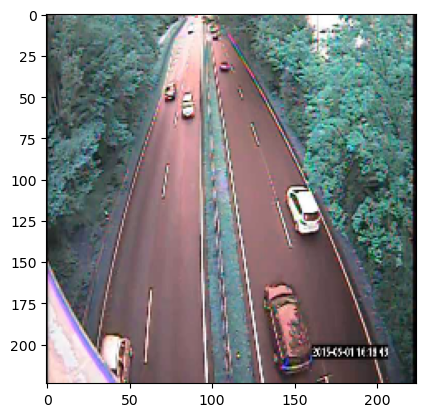

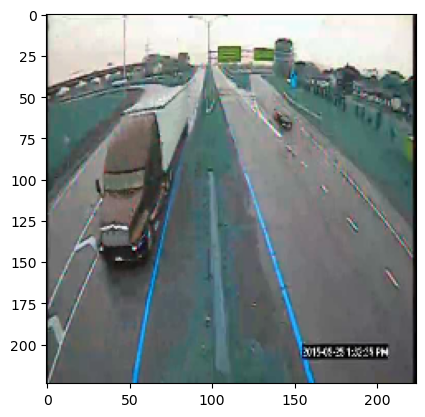

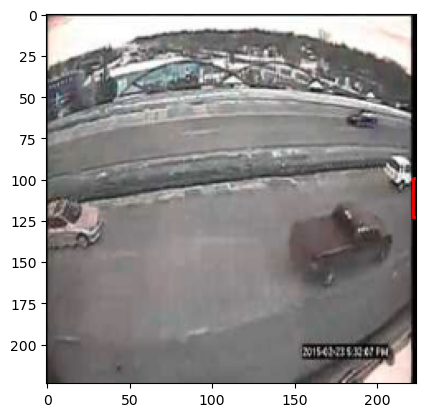

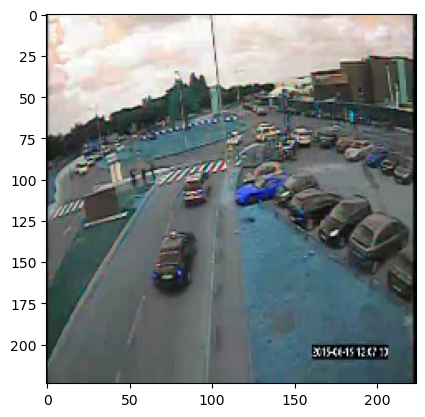

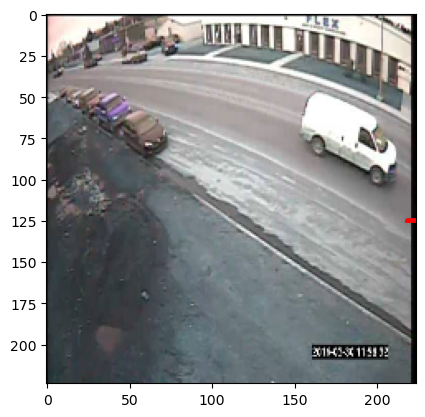

In [26]:
# Choose a few sample images for inference
sample_images = X_test[:5] # Adjust the number of sample images as needed

# Perform inference on the sample images
predictions = model.predict(sample_images)

# Extract the predicted bounding box coordinates
predicted_bounding_boxes = predictions[1]

# Visualize the sample images with predicted bounding boxes
for i in range(len(sample_images) ):
    plt.figure()
    plt.imshow(sample_images[i])
    plt.gca().add_patch(plt.Rectangle((predicted_bounding_boxes[i][0], predicted_bounding_boxes[i][1]),
                                        predicted_bounding_boxes[i][2] - predicted_bounding_boxes[i][0],
                                        predicted_bounding_boxes[i][3] - predicted_bounding_boxes[i][1],
                                        fill=False, edgecolor='r', linewidth=2))

plt.show()